In [1]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf                
from tqdm import tqdm

import numpy as np
import matplotlib.pylab as plt

import itertools
import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, learning_curve, GridSearchCV
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import keras
from keras import backend as K
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, model_from_json
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
%matplotlib inline

In [2]:
class_names = ['Bengin cases', 'Malignant cases', 'Normal cases']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (150, 150)

In [3]:
def load_data():
  
    datasets = ['Train', 'Test']
    output = []
    
    
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [4]:
(train_images, train_labels), (test_images, test_labels) = load_data()

  6%|████▉                                                                             | 7/115 [00:00<00:01, 62.90it/s]

Loading Train


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 89.25it/s]

Loading Test


In [5]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

In [6]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 1082
Number of testing examples: 15
Each image is of size: (150, 150)


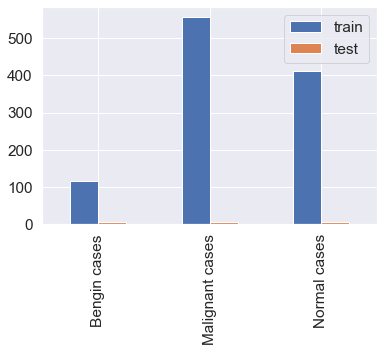

In [7]:
import pandas as pd

_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts}, 
             index=class_names
            ).plot.bar()
plt.show()

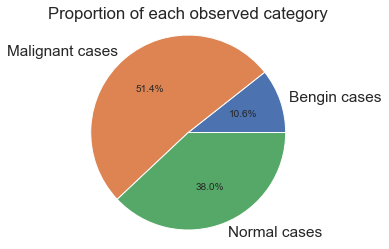

In [8]:
plt.pie(train_counts,
        explode=None , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

In [9]:
train_images = train_images / 255.0 
test_images = test_images / 255.0

In [14]:
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

model = VGG16(weights='imagenet', include_top=False)
model = Model(inputs=model.inputs, outputs=model.layers[-5].output)

In [15]:
train_features = model.predict(train_images)
test_features = model.predict(test_images)

In [17]:
from keras.layers import Input, Dense, Conv2D, Activation , MaxPooling2D, Flatten

model2 = VGG16(weights='imagenet', include_top=False)

input_shape = model2.layers[-4].get_input_shape_at(0) # get the input shape of desired layer
layer_input = Input(shape = (9, 9, 512)) # a new input tensor to be able to feed the desired layer
# https://stackoverflow.com/questions/52800025/keras-give-input-to-intermediate-layer-and-get-final-output

x = layer_input
for layer in model2.layers[-4::1]:
    x = layer(x)
    
x = Conv2D(32, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(128,activation='relu')(x)
x = Dense(3,activation='softmax')(x)

# create the model
new_model = Model(layer_input, x)
new_model = Model(layer_input, x)

In [18]:
new_model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [19]:
new_model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 9, 9, 512)]       0         
_________________________________________________________________
block5_conv1 (Conv2D)        multiple                  2359808   
_________________________________________________________________
block5_conv2 (Conv2D)        multiple                  2359808   
_________________________________________________________________
block5_conv3 (Conv2D)        multiple                  2359808   
_________________________________________________________________
block5_pool (MaxPooling2D)   multiple                  0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                

In [20]:
history = new_model.fit(train_features, train_labels, batch_size=128, epochs=20, validation_split = 0.2)

Epoch 1/20
7/7 [==============================] - 33s 5s/step - loss: 2.8194 - accuracy: 0.4208 - val_loss: 0.9900 - val_accuracy: 0.5023
Epoch 2/20
7/7 [==============================] - 35s 5s/step - loss: 0.9643 - accuracy: 0.5318 - val_loss: 0.8951 - val_accuracy: 0.5115
Epoch 3/20
7/7 [==============================] - 33s 5s/step - loss: 0.8513 - accuracy: 0.6312 - val_loss: 0.7383 - val_accuracy: 0.7189
Epoch 4/20
7/7 [==============================] - 32s 5s/step - loss: 0.7197 - accuracy: 0.7341 - val_loss: 0.6389 - val_accuracy: 0.7465
Epoch 5/20
7/7 [==============================] - 31s 4s/step - loss: 0.6351 - accuracy: 0.7584 - val_loss: 0.5728 - val_accuracy: 0.7696
Epoch 6/20
7/7 [==============================] - 30s 4s/step - loss: 0.5614 - accuracy: 0.7838 - val_loss: 0.4802 - val_accuracy: 0.8157
Epoch 7/20
7/7 [==============================] - 38s 5s/step - loss: 0.4693 - accuracy: 0.8173 - val_loss: 0.4835 - val_accuracy: 0.8111
Epoch 8/20
7/7 [==================

In [21]:
from sklearn.metrics import accuracy_score

predictions = new_model.predict(test_features)    
pred_labels = np.argmax(predictions, axis = 1)
print("Accuracy : {}".format(accuracy_score(test_labels, pred_labels)))

Accuracy : 0.9333333333333333


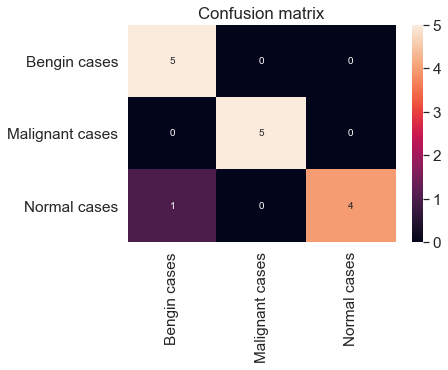

In [29]:
CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

In [30]:
#Print Classification Report
from sklearn.metrics import classification_report
print('Classification Report')

print(classification_report(test_labels,pred_labels))

Classification Report
              precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       1.00      1.00      1.00         5
           2       1.00      0.80      0.89         5

    accuracy                           0.93        15
   macro avg       0.94      0.93      0.93        15
weighted avg       0.94      0.93      0.93        15



Text(0.5, 1.0, 'Accuracy Curves')

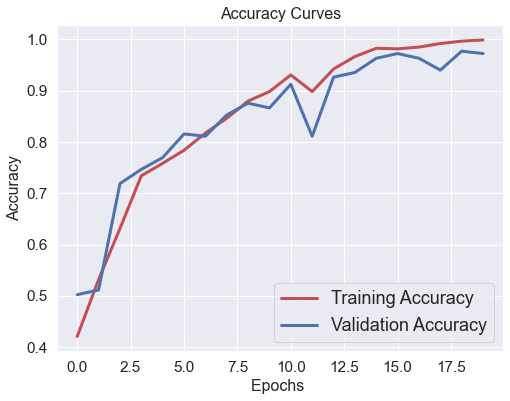

In [31]:
# Accuracy Curves

plt.figure(figsize=[8,6])

plt.plot(history.history['accuracy'],'r',linewidth=3.0)

plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)

plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)

plt.xlabel('Epochs ',fontsize=16)

plt.ylabel('Accuracy',fontsize=16)

plt.title('Accuracy Curves',fontsize=16)

Text(0.5, 1.0, 'Loss Curves')

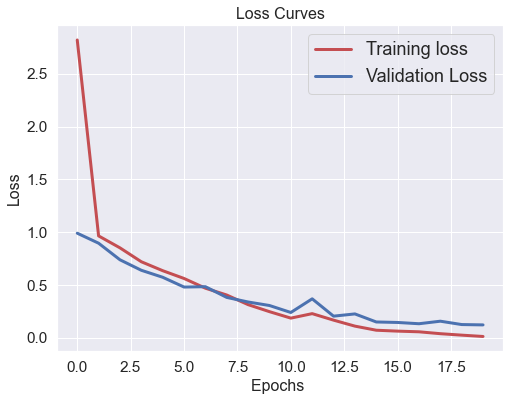

In [32]:
# Loss Curves

plt.figure(figsize=[8,6])

plt.plot(history.history['loss'],'r',linewidth=3.0)

plt.plot(history.history['val_loss'],'b',linewidth=3.0)

plt.legend(['Training loss', 'Validation Loss'],fontsize=18)

plt.xlabel('Epochs ',fontsize=16)

plt.ylabel('Loss',fontsize=16)

plt.title('Loss Curves',fontsize=16)